# Demo: Quantum Scattering
## Introduction

This iPython demo will start to give you some intuition for quantum scattering through a time dependent picture. 

To do this we will implement the Crank-Nicholson scheme, which provides an incredibly efficient and accurate technique for propagating wavefunctions forward in an implicit fashion. The technique works by assuming that:

$$\psi(t + dt) = \frac{1 - \frac{1}{2}i H dt }{1 + \frac{1}{2}i H dt} \psi(t) $$

Now, it's quite difficult to propagate this equation as written, but we find that it's relatively easy to write in an implicit fashion. This means that we're solving a system of equations where:

$$ (1 + \frac{1}{2}i H dt) \psi(t + dt) = (1 + \frac{1}{2}i H dt)^\dagger \psi(t ).$$
$$ A \psi(t + dt) = A^\dagger \psi(t ).$$


This can be thought of as the average of the forward propagator applied at time $t$ and the reverse propagator applied at time $t + dt.$ Then, this scheme basically works to ensure that quantum mechanics maintains its time-reversal symmetry at all times. This is precisely the bit that makes the Crank-Nicholson propagator very robust.

For the purpose of this demo we just want you get familiar with the steps of the propagation algorithm, as you will need it for the next homework. We also want you to play around with the initial conditions of propagation (momentum of the initial wavepacket and height of the barrier) and see how these conditions impact the scattering process.<br><br>


## <i class="fa fa-book"></i> Step 1: Import the required modules and define common variables.

Take note of the variables we are defining as you will have to play around with them. 

In [1]:
#Here is what we usually import
% matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import simps
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg
import scipy.integrate as integrate
from matplotlib import animation

# add all probables spots for the quantum world library
import sys
sys.path.append('../library')
sys.path.append('../../library')
sys.path.append('/home/student/chem160/library')
#This is how we'll import our own home-made modules
import quantumWorld as qworld


## Define grids and constants

In [29]:
m = 938.27        # mass
hbar = 0.1973        # hbar
c = 3.0e2         # speed of light

dx = 0.001 # Distance between x points
a = -1.2
b = 1.2
x = np.arange(a, b, dx)

T = 0.1 # Total time

dt = .1e-3 # dt
time_steps = int(T/dt) # Number of time steps
time = np.arange(0, T, dt)

## <i class="fa fa-book"></i> Step 2: Let's define some useful functions for the propagation.

Get familiar with the names of the following functions, as you will be calling them in the next steps.

In [30]:
##############################
# BLACK BOX METHODS
##############################

def Psi0(x, k=200000.0, x0 = -0.100):
    '''
    Initial state for a travelling gaussian wave packet.
    '''
    a  = 0.030 
    prefactor = (1.0/(2.0*np.pi*a**2))**0.25
    K1 = np.exp(-1.0*(x-x0)**2/(4.*a**2))
    K2 = np.exp(1j*k*x)
    return prefactor*K1*K2

def delta_abs(x, height = 5, cutoff = 0.4):
    '''
    This function takes in an array of positions and returns a scattering potential
    with absorbing boundary conditions.
    Just use as a black box
    '''
    potential = np.zeros(len(x), dtype=complex)
    potential[0.5*len(potential)] = height
    d = 0.1
    for i in range(len(x)):
        if x[i] >= cutoff:
            potential[i] = -1j*(1.0/(np.cosh((x[i] - cutoff)**2/d**2))**2 - 1.0)
        if x[i] <= -cutoff:
            potential[i] = -1j*(1.0/(np.cosh((x[i] + cutoff)**2/d**2))**2 - 1.0)
    return potential

def sparse_T(x, hbar, m, c):
    '''
    This method just returns the tridiagonal kinetic energy.
    It is the finite difference kinetic matrix we all know and love
    but it is incoded in a sparse matrix.
    NPUTS:
    x --> grid vector
    hbar -> planks constant
    m -> mass of expected particle
    c -> speed of light
    '''
    DX = x[1] - x[0]
    nx = len(x)
    prefactor = -(1j * hbar * c) / (2. * m)
    data = np.ones((3, nx))
    data[1] = -2 * data[1]
    diags = [-1, 0, 1]
    D2 = prefactor / DX**2 * sparse.spdiags(data, diags, nx, nx)
    return D2


def sparse_V(x, vx, hbar, c):
    '''
    This method just returns a sparse diagonal matrix with the potential
    on the diagonals and a Identity matrix of the same size.
    INPUTS:
    x --> grid vector
    vx --> potential evaluated at the grid vector
    hbar -> planks constant
    c -> speed of light
    '''
    nx = len(x)
    k2 = (1j * c) / hbar

    V_diags = [0]
    V = k2 * sparse.spdiags(vx, V_diags, nx, nx)
    I = sparse.identity(nx)
    return V, I


def forwardcn(psi, A, Ad):
    '''
    This method takes one step forward using the crank nicholson propagator. As promised, it uses the sparse solver
    to find where A \psi(t + dt) = A^\dagger \psi(t)
    '''
    psi = sparse.linalg.spsolve(A,Ad*psi)
    return psi


def animate_psi(x,psit):
    '''
    This method produces an animation of the saved wavefunctions. Note, this can be a slow method
    '''
    
    NFRAMES=200
    TIMESKIP=len(time)/float(NFRAMES)

    #We'll set up the figure for you
    fig = plt.figure()
    plt.xlim(np.min(x),np.max(x))
    # calcualte plot limits
    psit2=np.abs(psit)**2
    ymax=np.mean(psit2)+3.0*np.std(psit2)
    plt.ylim(0,ymax)
    plt.xlabel('x')
    plt.ylabel('$\psi$,$|\psi|$')
    plt.plot(x,vx)

    line, = plt.plot([], [], lw=2,label='$|\psi|$') #line is a plot.... 
    line1, = plt.plot([], [], lw=2,alpha=0.9,label='$\psi$') #line is a plot.... 
    plt.legend(loc='best')

    def init():
        '''
        Animation interior function
        '''
        line.set_data([], [])
        line1.set_data([], [])

        return

    def animate(t):
        '''
        Animation interior function
        '''
        time_index = TIMESKIP*t
        line.set_data(x, np.abs(psit[time_index,:])**2 )
        line1.set_data(x,psit[time_index,:].real )
        return
    
    ani = animation.FuncAnimation(fig, animate, frames=NFRAMES, init_func=init,blit=True)
    return ani

## <i class="fa fa-wrench"></i> Step 3: Now create a wavepacket to propagate. 

First, we need to create a wavepacket. Call the Psi0 method that is defined above. Note that k is the incoming momentum of the packet. For this first test, lets use k=-200.0. (The minus sign is related with the direction of the momentum. This wavepacket will move to the right.)

In [31]:
# Define the value of the momentum for your wavepacket
k_value=-100

# CALL THE FUNCTION Psi0 TO BUILD A WAVEPACKET WITH k=k_value AND INITIAL POSITION (x0) of -0.2
# assign it to the variable PsiaR (1 LINE)
psi0 = Psi0(x, x0=-0.2, k=k_value)
# normalizing the wavepacket
psi0 = qworld.normalize_wf(x,psi0)

# verifying normalization
print simps(np.abs(psi0)**2, x)

1.0


We will now generate the matrices for the potential energy and the kinetic energy, that we will use to build our Hamiltonian. We will also create an array to save the wavepacket wavefunctions as a function of time and the autocorrelation function.

In [32]:
# CALL THE FUNCTION build_KE THAT CONSTRUCT THE KINETIC ENERGY MATRIX (1 LINE)
# assign it to the variable D2
D2 = sparse_T(x, hbar, m, c)
# CALL THE FUNCTION sparse_V THAT CONSTRUCT THE POTENTIAL ENERGY MATRIX (2 LINES)
# assign the output to the variables V and I
vx =delta_abs(x)
V, I = sparse_V(x, vx, hbar, c)

# Generating an array to store the wavepacket at different times
psit = np.zeros((int((time_steps)/niter+1), len(psi0)), dtype=complex)
# generating a matrix to store the correlation function at different times
C = np.zeros(( int(time_steps/niter+1), ), dtype=complex)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:22: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Now assign to the first column of psit (psit[0, :]) the variable Psi, that corresponds to the initial wavepacket. Also compute the first element of the autocorrelation function. The autocorrelation function at a time $t'$ for the incident wavepacket is defined as:

$$ C(t')=\int \psi(t=0,x) \psi(t=t',x) dx $$

In [33]:
# ASSIGN Psi TO THE FIRST ELEMENT OF THE VARIABLES psit (1 LINe)
psit[0, :] = psi0

# COMPUTE THE AUTOCORRELATION FUNCTION AT t=0 (1 LINE)  
C[0] = simps(psit[0, :].conjugate()*psit[0, :], x)

## <i class="fa fa-wrench"></i> Step 4: Perform the propagation

The first thing we need to do before propagating is computing the $A$ (A) and $A^\dagger$ (Ad) Matrices required for the Crank-Nicholson propagation. According to the introduction these matrices will be given by:
$$A = I - \frac{dt}{2}(D2 + V) $$
and
$$A^\dagger = I + \frac{dt}{2}(D2+V)$$
(Note that D2 already has the imaginary prefactor)

In [34]:
# DEFINE THE A AND A^{dagger} MATRICES (2 LINES)
# Remember we have defined the kinetic energy and potential energy matrix in the previous step as D2 and V.
A = I - dt/2.0*(D2+V)
Ad = I + dt/2.0*(D2+V)

Now fill in the loop such that it updates the wavefunction *Psiar* using the *forwardcn* method and fill in the correlation function computation.

In [35]:
for i in range(1,time_steps):
    # CALL THE forwardcn FUNCTION TO PROPAGATE 1 TIME STEP, ASSIGN THE RESULT TO psi_now (1 LINE)
    psi_now = forwardcn(psit[i-1, :], A, Ad)
    # SAVE THE NEW psi_now VALUE TO THE i-th ELEMENT OF THE psit MATRIX (1 LINE)
    psit[i, :] = psi_now
    # COMPUTE THE AUTOCORRELATION FUNCTION FOR THE i-th TIME STEP (1 LINE)  
    C[i] = simps(psit[0, :].conjugate()*psit[i, :], x)


Now we will plot the value of the autocorrelation function as a function of time.

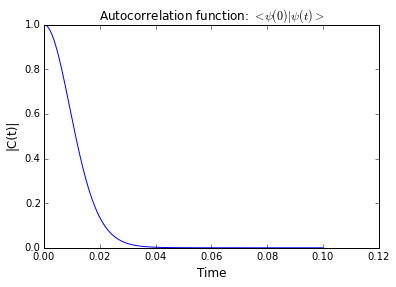

In [36]:
tarray=dt*np.arange(0,len(C))
plt.figure(1)
plt.ylabel('|C(t)|',fontsize=12)
plt.xlabel('Time',fontsize=12)
plt.title("Autocorrelation function: $<\psi(0) | \psi(t)>$")
plt.plot(tarray,np.abs(C))
plt.show()

## <i class="fa fa-book"></i> Step 6: Animate the propagation.

In [37]:
anim=animate_psi(x,psit)
qworld.embedAnimation(anim,plt)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:117: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:118: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## <i class="fa fa-wrench"></i> Step 7: Time to play around.

Now we want you to play around with the momentum and the shape of the potential.

1. Now, try a smaller k (Let's say k=-800). What happens with the transmission? Note that k is related to the temperature, so a larger k corresponds to a higher temperature and a smaller k to a lower temperature.
1. Change the height of the potential in the definition of the function delta_abs. The default value is 5, raise it to 10. How does that change the transmission?